<a href="https://colab.research.google.com/github/gyesibiney/movie-review-sentiment-analysis/blob/main/Capstone_FineTuning_Roberta.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%%capture

!pip install transformers
!pip install accelerate -U
!pip install datasets
!pip install huggingface_hub

In [ ]:
%%capture

import torch
from sklearn.metrics import accuracy_score
import pandas as pd
import numpy as np

from transformers import AutoTokenizer, AutoModelForSequenceClassification
from sklearn.model_selection import train_test_split
from transformers import pipeline
from datasets import load_dataset
import nltk
nltk.download('punkt')
##others
import warnings
warnings.filterwarnings("ignore")
import os
os.environ["WANDB_DISABLED"] = "true"
pd.set_option("display.max_rows", 50)
pd.set_option("display.max_columns", 50)

In [ ]:
# Disabe W&B
os.environ["WANDB_DISABLED"] = "true"

## Importing Dataset

In [ ]:
data_path= '/content/drive/MyDrive/data/movie_review_dataset.csv'

In [ ]:
data= pd.read_csv(data_path)

In [ ]:
data.head()

,content,label,clean_content
0,recently shown on cable tv the movie opens wit...,1,recently shown on cable tv the movie opens wit...
1,i was very surprised with this film. i was tou...,1,i was very surprised with this film i was tou...
2,"now, i'm one to watch movies that got poor rev...",0,now i m one to watch movies that got poor rev...
3,"this film came out 12 years years ago, and was...",1,this film came out 12 years years ago and was...
4,"when an orphanage manager goes on vacation, hi...",1,when an orphanage manager goes on vacation hi...


In [ ]:
##checking for missing values

data.isna().sum()

content          0
label            0
clean_content    0
dtype: int64

### Data Splitting

In [ ]:
train, eval = train_test_split(data, test_size= 0.2, random_state= 42,stratify=data['label'])

In [ ]:
train.shape

(19923, 3)

In [ ]:
eval.shape

(4981, 3)

 # iii. Loading Datasets using Load_dataset

In [ ]:
train.to_csv("/content/train_set.csv")
eval.to_csv("/content/eval_set.csv")

In [ ]:
dataset= load_dataset("csv", data_files={"train_set":"train_set.csv", "eval_set":"eval_set.csv" }, encoding= "ISO-8859-1")

Extracting data files:   0%|          | 0/2 [00:00<?, ?it/s]

Generating train_set split: 0 examples [00:00, ? examples/s]

Generating eval_set split: 0 examples [00:00, ? examples/s]

In [ ]:
dataset

DatasetDict({
    train_set: Dataset({
        features: ['Unnamed: 0', 'content', 'label', 'clean_content'],
        num_rows: 19923
    })
    eval_set: Dataset({
        features: ['Unnamed: 0', 'content', 'label', 'clean_content'],
        num_rows: 4981
    })
})

###. Tokenization

In [ ]:
tokenizer= AutoTokenizer.from_pretrained("roberta-base")

In [ ]:
## our labels are-1, and 1 and we will like to transform them into 0,1, respectively

def transform_labels(input):
  label= input["label"]
  num =0

  if label== 0:
    num= 0  ##for negative sentiment
  elif label== 1:
    num =1 ##for positive sentiment
  return {"labels": num}

def tokenize(example):
  return tokenizer(example["clean_content"], padding= "max_length", truncation=True, return_tensors= "pt")

In [ ]:
dataset= dataset.map(tokenize, batched= True)
remove_columns=  ['Unnamed: 0', 'label', 'content', 'clean_content']
dataset = dataset.map(transform_labels, remove_columns=remove_columns)

Map:   0%|          | 0/19923 [00:00<?, ? examples/s]

Map:   0%|          | 0/4981 [00:00<?, ? examples/s]

Map:   0%|          | 0/19923 [00:00<?, ? examples/s]

Map:   0%|          | 0/4981 [00:00<?, ? examples/s]

In [ ]:
dataset

DatasetDict({
    train_set: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 19923
    })
    eval_set: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 4981
    })
})

## ii.Modelling

In [ ]:
model= AutoModelForSequenceClassification.from_pretrained("roberta-base", num_labels= 2)

In [ ]:
def compute_metrics(pred):
  labels = pred.label_ids
  preds = pred.predictions.argmax(-1)
  accuracy = accuracy_score(labels, preds)
  return {"accuracy": accuracy}

In [ ]:
batch_size= 16

In [ ]:
from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir="Roberta-capstone_2",
    num_train_epochs=5,
    load_best_model_at_end=True,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    push_to_hub=True,
    per_device_train_batch_size=16,  # Reducing batch size can sometimes mitigate overfitting
    weight_decay=0.01,  # Adding weight decay to handle overfitting
    gradient_accumulation_steps=2  # This helps in effectively reducing the batch size

)

In [ ]:
train_dataset= dataset['train_set'].shuffle(seed=10)
eval_dataset= dataset['eval_set'].shuffle(seed=10)

In [ ]:
from huggingface_hub import notebook_login

notebook_login()

In [ ]:
from transformers import Trainer

In [ ]:
trainer= Trainer(
    model= model,
      args= training_args,
      train_dataset= train_dataset,
      eval_dataset= eval_dataset,
      tokenizer= tokenizer,
      compute_metrics=compute_metrics

)

In [ ]:
trainer.train()

Epoch,Training Loss,Validation Loss


Epoch,Training Loss,Validation Loss,Accuracy
1,0.256800,0.197138,0.926521
2,0.158100,0.210172,0.933949
3,0.109000,0.312584,0.935555
4,0.068700,0.303979,0.938165
5,0.019900,0.348470,0.939972


TrainOutput(global_step=3115, training_loss=0.10613454639624631, metrics={'train_runtime': 10562.5463, 'train_samples_per_second': 9.431, 'train_steps_per_second': 0.295, 'total_flos': 2.62098077796864e+16, 'train_loss': 0.10613454639624631, 'epoch': 5.0})

In [ ]:
trainer.push_to_hub()

'https://huggingface.co/gyesibiney/Roberta-capstone_2/tree/main/'

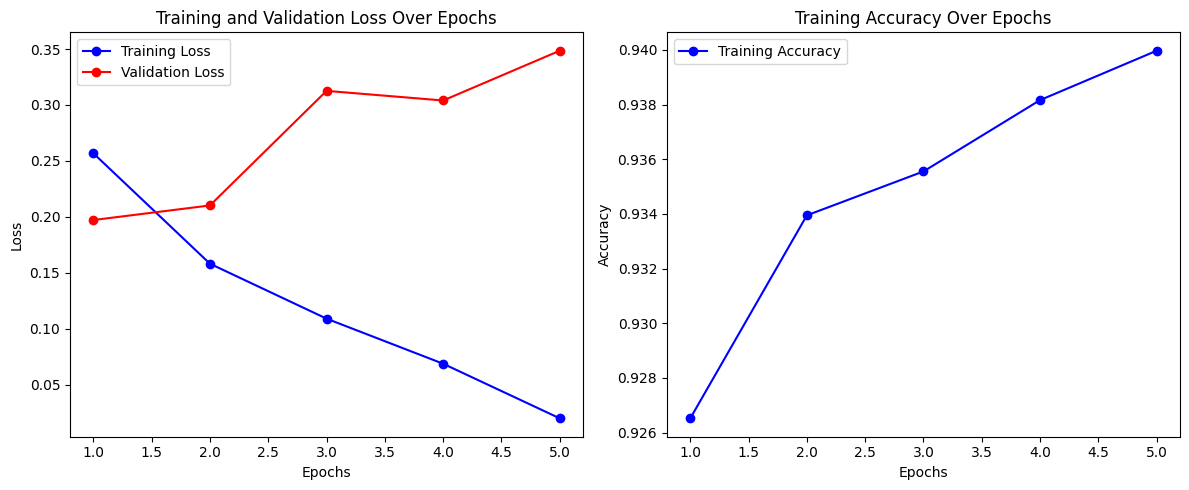

In [ ]:
import matplotlib.pyplot as plt

# Define the number of epochs
epochs = [1, 2, 3, 4, 5]

# Define the training and validation loss values
training_loss = [0.256800, 0.158100, 0.109000, 0.068700, 0.019900]
validation_loss = [0.197138, 0.210172, 0.312584, 0.303979, 0.348470]

# Define the training and validation accuracy values
training_accuracy = [0.926521, 0.933949, 0.935555, 0.938165, 0.939972]

# Create subplots for loss and accuracy
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Plot training and validation loss
ax1.plot(epochs, training_loss, label='Training Loss', marker='o', linestyle='-', color='b')
ax1.plot(epochs, validation_loss, label='Validation Loss', marker='o', linestyle='-', color='r')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.set_title('Training and Validation Loss Over Epochs')
ax1.legend()

# Plot training and validation accuracy
ax2.plot(epochs, training_accuracy, label='Training Accuracy', marker='o', linestyle='-', color='b')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.set_title('Training Accuracy Over Epochs')
ax2.legend()

plt.tight_layout()
plt.show()
